# Independent Component Analysis: Infomax

## Exercise 5.1:  Initialization

In [9]:
import numpy as np
import numpy.linalg as linalg

N = 2

s1 = np.loadtxt("sounds/sound1.dat")
s2 = np.loadtxt("sounds/sound2.dat")

S = np.stack((s1, s2))

Calculate random invertible mixing matrix $A$:

In [10]:
A = np.random.rand(N, N)
while linalg.det(A) == 0:
    print("A not invertible, recreating...")
    A = np.random.rand(N, N)

Mix sources $S$ using $A$:

In [11]:
X = A @ S
X.shape

(2, 18000)

 Test if matrix calculation is correct:

In [12]:
A @ S[:,10] == X[:,10]

array([ True,  True])

Shuffle data to remove temporal structure:

In [13]:
X = X[:, np.random.permutation(X.shape[1])]

Correlations between mixtures and sources:

In [14]:
P = np.zeros((N, N))
for i in np.arange(N):
    for j in np.arange(N):
        si = S[i]
        xj = X[j]
        pij = (np.cov(si, xj) / (np.std(si) * np.std(xj)))[0, 1]
        P[i, j] = pij
        
P

array([[-0.01256866, -0.01323699],
       [-0.0063357 , -0.00470596]])

Center mixing data:

In [10]:
mean = X.mean(axis=1)

In [11]:
X = X - mean[:, np.newaxis]

Initialize unmixing matrix $W$ with random values:

In [12]:
W = np.random.rand(N, N)

## Exercise 5.2:  Optimization

In [39]:
sigmoid = lambda x: 1. / (1. + np.exp(-x))

Using *standard gradient*:

In [30]:
t = 1
epsilon_0 = 1
W = np.random.rand(N, N)
for x in X.T:
    epsilon = epsilon_0 / t
    deltaW = epsilon * (linalg.inv(W).T + (1 - 2 * sigmoid(W @ x)).T @ x)
    W += deltaW
    t += 1
print(W)

[[-18.0194211    7.04756099]
 [  8.3134143   -0.52306307]]


Using *natural gradient*:

In [38]:
t = 1
epsilon_0 = 1
W = np.random.rand(N, N).astype(np.float128)
for x in np.tile(X, 100).T:
    epsilon = epsilon_0 / t
    deltaW = epsilon * ((np.identity(N) + (1 - 2 * sigmoid(W @ x)) @ (W @ x).T) @ W)
    W += deltaW
    t += 1
print(W)

<ipython-input-29-1f682844f54a>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x, dtype=np.float128))


[[-291521.14350897  570204.79558805]
 [ 291521.14350897 -570204.79558805]]


In [65]:
# From solution (seems to work)
def ica_natgrad_componentwise(x_alpha, N, W):
    dW = np.zeros_like(W)
    for i in range(N):
        for j in range(N):
            wk = np.dot(W[i,:], x_alpha)
            for ll in range(N):
                dil = int(i == ll)
                fpp_fp = 1. - 2. * sigmoid(wk)
                dW[i, j] += (dil + fpp_fp * np.dot(W[ll, :], x_alpha)) * W[ll, j]
    return dW

W = np.random.rand(N, N)
t = 1

# iterate multiple times over the data
for i in range(10):
    for x in X.T:
        W += (1 / t) * ica_natgrad_componentwise(x, N, W)
        t += 1
    
print(W)

[[-13.19170434   6.12137403]
 [  1.17929495  -3.06248879]]


Exponentially decaying learning rate:

In [59]:
def learning_rate(t):
    return np.exp(0.0001 * -t)

print(learning_rate(18001))

0.16528235915923126


In [119]:
t = 1
epsilon_0 = 1
W = np.random.rand(N, N)
for x in X.T:
    epsilon = learning_rate(t)
    deltaW = epsilon * (linalg.inv(W).T + (1 - 2 * sigmoid(W @ x)).T @ x)
    W += deltaW
    t += 1
print(W)

[[ 25.52908685  40.15427139]
 [-36.28272283  25.54580148]]


In [112]:
t = 1
W = np.random.rand(N, N)
for x in X.T:
    epsilon = learning_rate(t)
    deltaW = epsilon * (np.identity(N) + (1 - 2 * sigmoid(W @ x)) @ (W @ x).T) @ W
    W += deltaW
    t += 1
print(W)

/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in matmul
  """
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in matmul
  """
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  


[[nan nan]
 [nan nan]]


## Exercise 5.3: Results

In [122]:
from scipy.io import wavfile

rate = s1.shape[0] // 2

wavfile.write("s1.wav", rate, s1)
wavfile.write("s2.wav", rate, s2)

wavfile.write("s1_s2.wav", rate, S.T)
wavfile.write("s1_s2_mixed.wav", rate, (A @ S).T)
wavfile.write("s1_s2_mixed_permuted.wav", rate, X.T)

print(W)
print(A)
print(W @ A)
wavfile.write("unmixed.wav", rate, ((W @ A @ S)).T)

[[ 25.52908685  40.15427139]
 [-36.28272283  25.54580148]]
[[0.36247556 0.35558544]
 [0.44420594 0.43490774]]
[[27.09043571 26.54117505]
 [-1.80400351 -1.79154101]]


Original sounds:

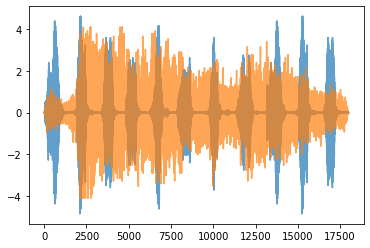

In [139]:
import matplotlib.pyplot as plt

plt.plot(np.arange(s1.shape[0]), s1, alpha=0.7)
plt.plot(np.arange(s2.shape[0]), s2, alpha=0.7)

Mixed sounds:

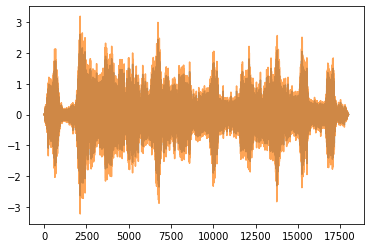

In [138]:
import matplotlib.pyplot as plt

plt.plot(np.arange(s1.shape[0]), (A @ S)[0], alpha=0.7)
plt.plot(np.arange(s2.shape[0]), (A @ S)[1], alpha=0.7)

Unmixed sounds:

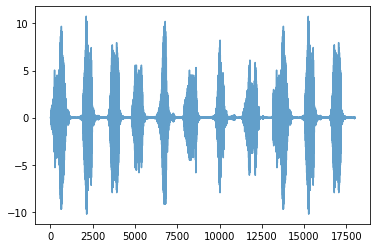

In [66]:
import matplotlib.pyplot as plt

X_orig = A @ S

plt.plot(np.arange(s1.shape[0]), (W @ X_orig)[0], alpha=0.7)

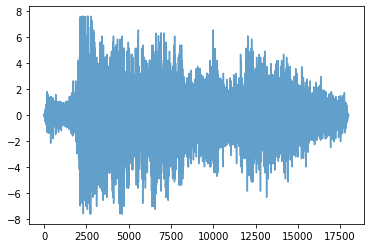

In [67]:
plt.plot(np.arange(s2.shape[0]), (W @ X_orig)[1], alpha=0.7)